In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('fivethirtyeight')
%matplotlib inline
import pandas as pd
from datetime import datetime
import seaborn as sns
sns.set()
import warnings; warnings.simplefilter("ignore")
import datetime as dt
import missingno as msno

In [2]:
m_regime = pd.read_csv (r'C:\Users\admin\OneDrive - nyu.edu\Spring 2022\Capstone\Master Table\Regime_Weekly.csv')

In [3]:
def label_regime(row):
    if row["Quarter_mean"] > 3:
        return 2
    elif row["Quarter_mean"] < -3:
        return 0
    else:
        return 1

In [4]:
def smooth_regime(df):
    x = df.shift(1) == df
    y = x.shift(1) != x
    y = y[1:]
    y.reset_index(inplace=True)
    x = x[:-1]
    boolean = x["regime"] | y["regime"]
    df["bol"] = boolean
    
    df.loc[df.loc[df.bol == False].index,"regime"] = np.nan
    df.fillna(method = "ffill", inplace = True)
    return

In [5]:
# avg.drop("regime",axis=1,inplace=True)
m_regime["Quarter_mean"] = m_regime["avg_ret"].rolling(4).mean()
m_regime.fillna(method="bfill",inplace=True)
m_regime.fillna(method="ffill",inplace=True)

m_regime["regime"] = m_regime.apply(lambda x: label_regime(x),axis = 1)
# avg.head()

In [6]:
smooth_regime(m_regime)

In [7]:
#m_regime.to_csv(r'D:\Financial Engineering\.Spring2022_CapstoneProjects\Mastertable\m_regime.csv')

In [8]:
sp500 = pd.read_csv (r'C:\Users\admin\OneDrive - nyu.edu\Spring 2022\Capstone\Master Table\SP500_Weekly.csv')
sp500 = sp500.set_index(pd.to_datetime(sp500['Date']))

## Prepare Y sets and X sets

In [9]:
def graph_state(predicted_state, sp500, modelname, col_name):
    final = predicted_state[[col_name]].join(sp500[["SP500",'Date']])
    final["Date"] = pd.to_datetime(final['Date'])
    fg = sns.FacetGrid(final, hue = col_name,height = 8,aspect=1.5)
    fg.map_dataframe(sns.scatterplot, x= "Date", y ="SP500",alpha=0.8).add_legend()
    fg.fig.suptitle("S&P500 states with " + modelname)
    plt.show()

In [10]:
y_monthly = m_regime[['Date', 'regime']].set_index(pd.to_datetime(m_regime['Date'])).drop(columns=['Date'])

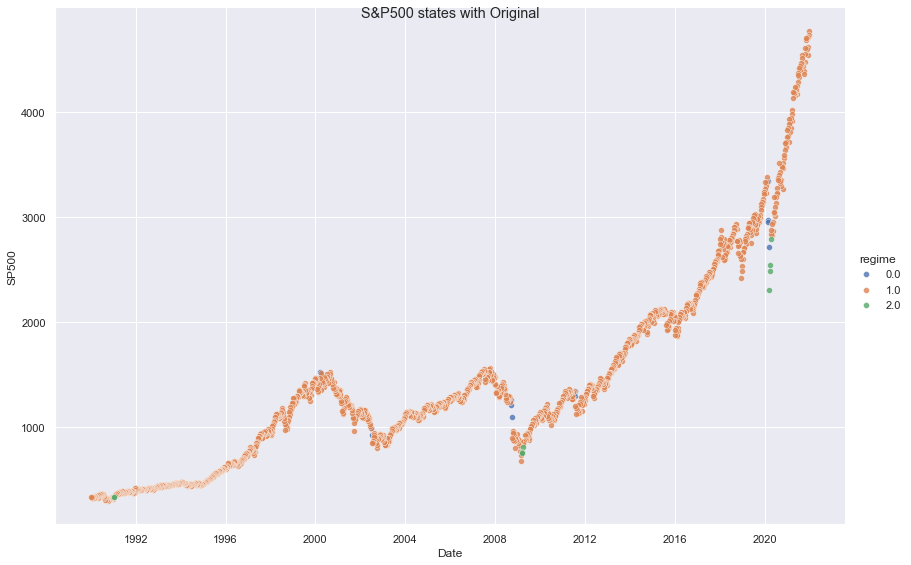

In [11]:
graph_state(y_monthly, sp500, 'Original', 'regime')

In [12]:
master_monthly = pd.read_csv (r'C:\Users\admin\OneDrive - nyu.edu\Spring 2022\Capstone\Master Table\Model_Master_Weekly.csv')
master_monthly = master_monthly.set_index(pd.to_datetime(master_monthly['Date'])).drop(columns=['Date'])
master_monthly = master_monthly.fillna(0)

In [13]:
from statsmodels.tsa.stattools import adfuller
non_stationary = []
for i in master_monthly.columns:
    dftest = adfuller(master_monthly[i], autolag = 'AIC')
    if dftest[0] < dftest[4]["5%"]:
        #print('reject Ho - it is stationary')
        continue
    else:
        print(i+': failed to reject Ho - it is non-stationary')
        print("P-Value : ", dftest[1])
        non_stationary.append(i)

b30: failed to reject Ho - it is non-stationary
P-Value :  0.2079316935210428
b1: failed to reject Ho - it is non-stationary
P-Value :  0.23070040312834295
bond10: failed to reject Ho - it is non-stationary
P-Value :  0.7598777255168537
bond5: failed to reject Ho - it is non-stationary
P-Value :  0.6601661538341844
bond3: failed to reject Ho - it is non-stationary
P-Value :  0.09731087725840282
log_commodity: failed to reject Ho - it is non-stationary
P-Value :  0.4417724673074637
yield_diff: failed to reject Ho - it is non-stationary
P-Value :  0.06936959378903142


In [14]:
for i in non_stationary:
    master_monthly[i] = master_monthly[i].diff()

In [15]:
master_monthly = master_monthly.fillna(0)

In [16]:
non_stationary = []
for i in master_monthly.columns:
    dftest = adfuller(master_monthly[i], autolag = 'AIC')
    if dftest[0] < dftest[4]["5%"]:
        #print('reject Ho - it is stationary')
        continue
    else:
        print(i+': failed to reject Ho - it is non-stationary')
        print("P-Value : ", dftest[1])
        non_stationary.append(i)
if(len(non_stationary)==0):
    print('All stationary')

All stationary


## Model 1: Kmean Cluster

In [17]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3)
model.fit(master_monthly)
predicted_state = model.predict(master_monthly)
regimes = np.unique(predicted_state)

Kmean_state = pd.DataFrame(predicted_state, columns = ["state"],index = master_monthly.index)

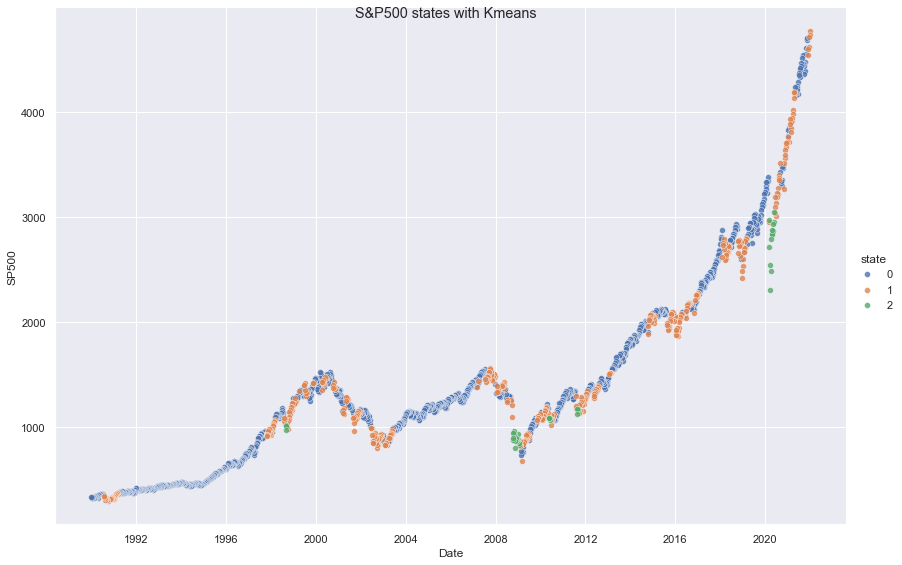

In [18]:
graph_state(Kmean_state,sp500,'Kmeans',"state" )

## HMM Model

In [19]:
from hmmlearn import hmm
hmm_model = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=100)
model = hmm_model.fit(master_monthly)
hidden_state = model.predict(master_monthly)

In [20]:
""" 
#=============OLD ONE==================================
import sklearn.mixture as mix
X = master_monthly.values
model = mix.GaussianMixture(n_components=3, covariance_type="full", n_init=100,random_state=7).fit(X)
hidden_state = model.predict(X)
"""

' \n#=============OLD ONE==================================\nimport sklearn.mixture as mix\nX = master_monthly.values\nmodel = mix.GaussianMixture(n_components=3, covariance_type="full", n_init=100,random_state=7).fit(X)\nhidden_state = model.predict(X)\n'

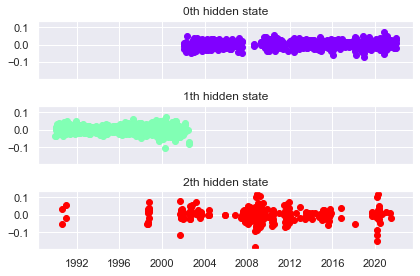

In [21]:
fig,axs = plt.subplots(model.n_components, sharex=True, sharey=True)
colors = cm.rainbow(np.linspace(0,1,model.n_components))

for i, (ax,color) in enumerate(zip(axs,colors)):
    mask = hidden_state == i 
    ax.plot(master_monthly.index.values[mask],
                 master_monthly["SP500pct"].values[mask],
                "o", c = color)
    ax.set_title("{}th hidden state".format(i))
    
plt.tight_layout()

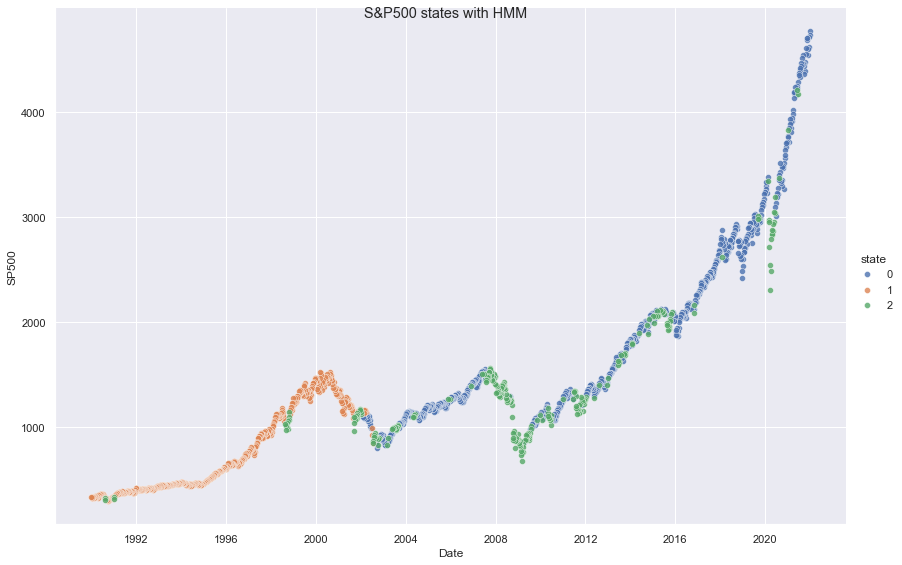

In [22]:
HMM_state = pd.DataFrame(hidden_state, columns = ["state"],index = master_monthly.index)
graph_state(HMM_state,sp500,'HMM',"state" )

## Supervised Model

In [23]:
master_monthly2 = master_monthly.drop(['SP500pct'], axis=1).sort_index(ascending=True)
y_monthly2 = y_monthly.sort_index(ascending=True)

In [24]:
train_len = int(master_monthly2.shape[0]*0.8)
test_len = master_monthly2.shape[0] - train_len
X_train, y_train = master_monthly2.iloc[:train_len+1,:], y_monthly2.iloc[:train_len+1,:] 
X_test, y_test = master_monthly2.iloc[train_len+1:, :], y_monthly2.iloc[train_len+1:, :] 

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
 
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

models = {"LinearDiscriminantAnalysis": LinearDiscriminantAnalysis(),
         "LogisticRegression": LogisticRegression(), 
          "Support Vector Machine":SVC(probability=True),
          "DecisionTree":DecisionTreeClassifier(),
         "RandomForestClassifier": RandomForestClassifier(), 
         "AdaBoostClassifier": AdaBoostClassifier(),
         "GradientBoostingClassifier":GradientBoostingClassifier()}

### GridSearch for each model 

In [26]:
from scipy.stats import loguniform
# define grid
grid_linear = {}
grid_linear['solver'] = ['svd', 'lsqr', 'eigen']

grid_logistic = {}
grid_logistic['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
grid_logistic['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
grid_logistic['C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]

grid_svc = {}
grid_svc['C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2,10**3]
grid_svc['gamma'] = [10**-2, 10**-1, 10**0, 10**1, 10**2,10**3]

grid_dt ={}
grid_dt['max_depth'] = [5,10,25,None]
grid_dt['min_samples_split'] = [2,5,10]
grid_dt['class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]

grid_rf = {}
grid_rf['n_estimators'] = [10, 50, 100, 250]
grid_rf['max_depth'] = [5, 10, 20]
grid_rf['class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]

grid_ada ={}
grid_ada['n_estimators'] = [10, 50, 100, 500]
grid_ada['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]

grid_gb = {}
grid_gb['n_estimators'] = [10, 50, 100, 250]
grid_gb['max_depth'] = [5, 10, 20]

In [27]:
models_grid = {"LinearDiscriminantAnalysis": grid_linear,
         "LogisticRegression": grid_logistic, 
          "Support Vector Machine":grid_svc,
          "DecisionTree":grid_dt,
         "RandomForestClassifier": grid_rf, 
         "AdaBoostClassifier": grid_ada,
         "GradientBoostingClassifier":grid_gb}

In [28]:
from sklearn.model_selection import GridSearchCV

for name,method in models.items():
    _model = method
    # define search
    search = GridSearchCV(_model, models_grid[name], scoring='accuracy', cv=cv, n_jobs=-1)
    # perform the search
    results = search.fit(master_monthly2, y_monthly2)
    # summarize
    print(name)
    print('Mean Accuracy: %.3f' % results.best_score_)
    print('Config: %s' % results.best_params_)

LinearDiscriminantAnalysis
Mean Accuracy: 0.966
Config: {'solver': 'svd'}
LogisticRegression
Mean Accuracy: 0.985
Config: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Support Vector Machine
Mean Accuracy: 0.986
Config: {'C': 10, 'gamma': 10}
DecisionTree
Mean Accuracy: 0.984
Config: {'class_weight': {0: 1, 1: 10}, 'max_depth': 10, 'min_samples_split': 10}
RandomForestClassifier
Mean Accuracy: 0.986
Config: {'class_weight': None, 'max_depth': 20, 'n_estimators': 250}
AdaBoostClassifier
Mean Accuracy: 0.985
Config: {'learning_rate': 0.1, 'n_estimators': 100}
GradientBoostingClassifier
Mean Accuracy: 0.984
Config: {'max_depth': 5, 'n_estimators': 250}


In [29]:
#redefine each model
models = {"LinearDiscriminantAnalysis": LinearDiscriminantAnalysis( solver= 'svd'),
         "LogisticRegression": LogisticRegression(C= 0.01, penalty='l1', solver='liblinear'), 
          "Support Vector Machine":SVC(probability=True, C= 10,gamma=10),
          "DecisionTree":DecisionTreeClassifier(class_weight= {0: 1, 1: 10}, max_depth= 5, min_samples_split= 10),
         "RandomForestClassifier": RandomForestClassifier(class_weight= {0: 1, 1: 10}, max_depth=10, n_estimators= 100), 
         "AdaBoostClassifier": AdaBoostClassifier(learning_rate= 0.1, n_estimators= 100),
         "GradientBoostingClassifier":GradientBoostingClassifier(max_depth= 5, n_estimators= 250)}

In [30]:
fitted_model={}
for name,method in models.items():
    _model = method
    _model.fit(X_train,y_train)
    fitted_model[name] = _model
    print("{} cross validation score is: {:.3f}".format(name, cross_val_score(_model, master_monthly2, y_monthly2, cv=cv).mean()))

LinearDiscriminantAnalysis cross validation score is: 0.966
LogisticRegression cross validation score is: 0.985
Support Vector Machine cross validation score is: 0.986
DecisionTree cross validation score is: 0.984
RandomForestClassifier cross validation score is: 0.985
AdaBoostClassifier cross validation score is: 0.985
GradientBoostingClassifier cross validation score is: 0.984


In [31]:
assess = {}
tests=['ROC','Accuracy']
for test in tests:
    temp_test={}
    for name, _model in fitted_model.items():
        y_hat = _model.predict(X_test)
        y_prob = _model.predict_proba(master_monthly2)
        y_monthly2[name+"_Predicted"] = _model.predict(master_monthly2)
        y_test[name+"_Predicted"] = y_hat
        if test =="ROC":
            temp_test[name] = roc_auc_score(y_monthly2["regime"], y_prob, multi_class='ovr')
        else:
            temp_test[name] = accuracy_score(y_test["regime"], y_hat)
    assess[test] = temp_test

pd.DataFrame(assess)
#The more area under ROC the better

,ROC,Accuracy
LinearDiscriminantAnalysis,0.826506,0.966967
LogisticRegression,0.112409,0.975976
Support Vector Machine,0.994584,0.975976
DecisionTree,0.690382,0.975976
RandomForestClassifier,0.997591,0.975976
AdaBoostClassifier,0.917625,0.972973
GradientBoostingClassifier,0.948408,0.978979


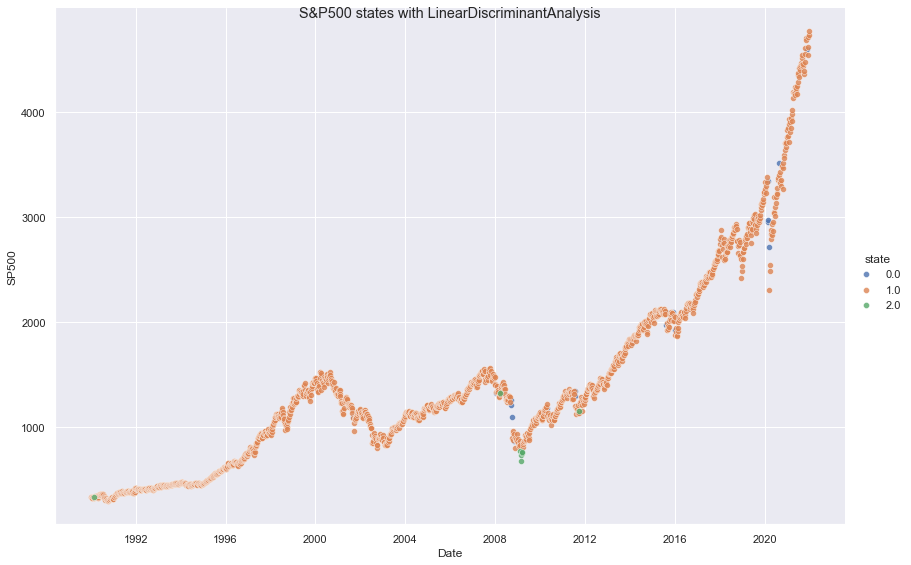

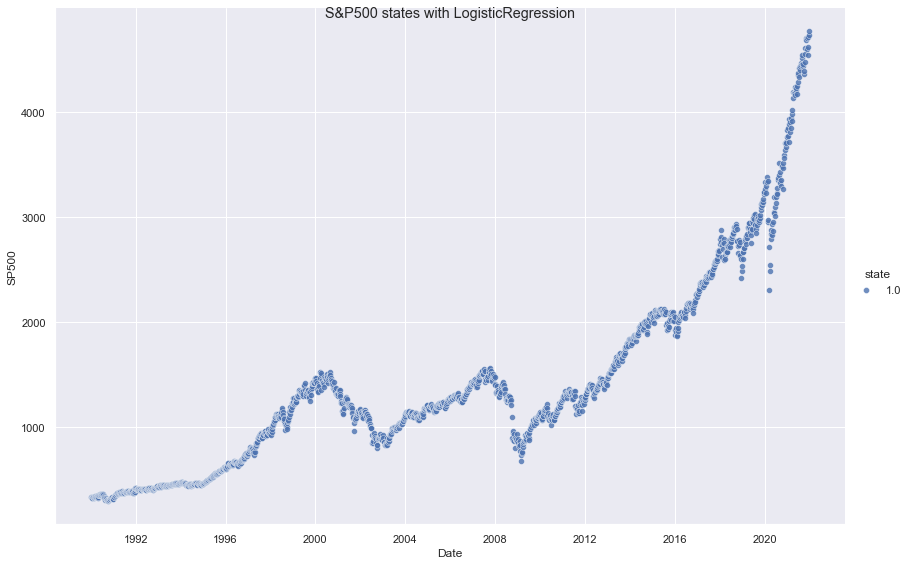

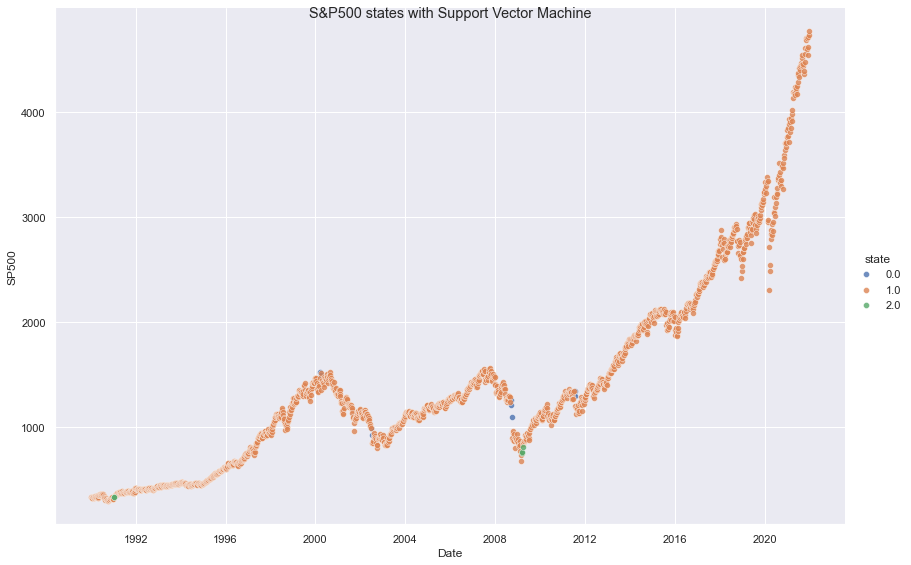

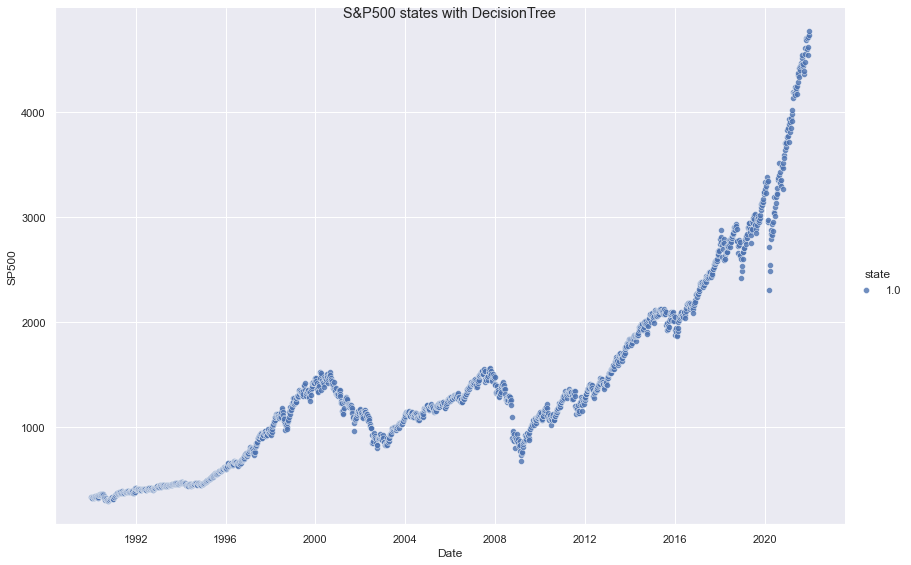

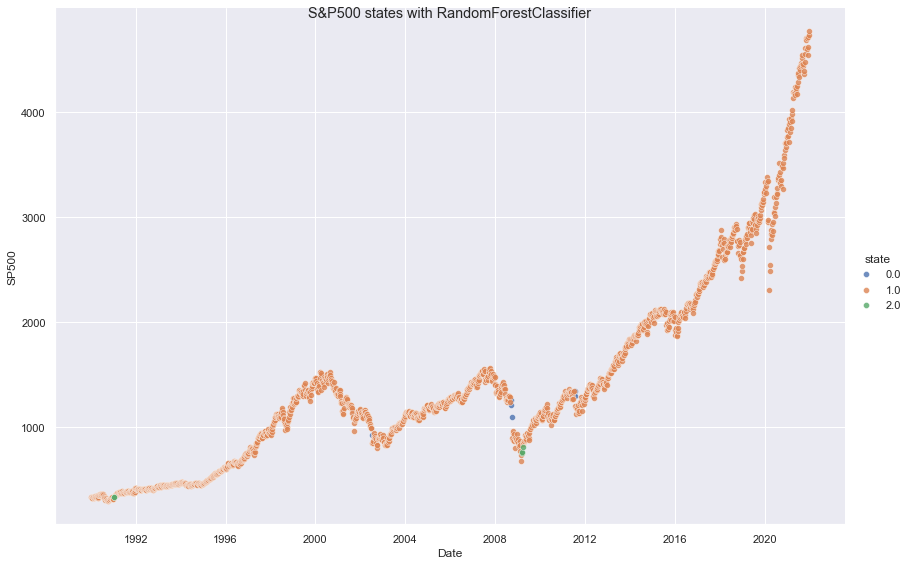

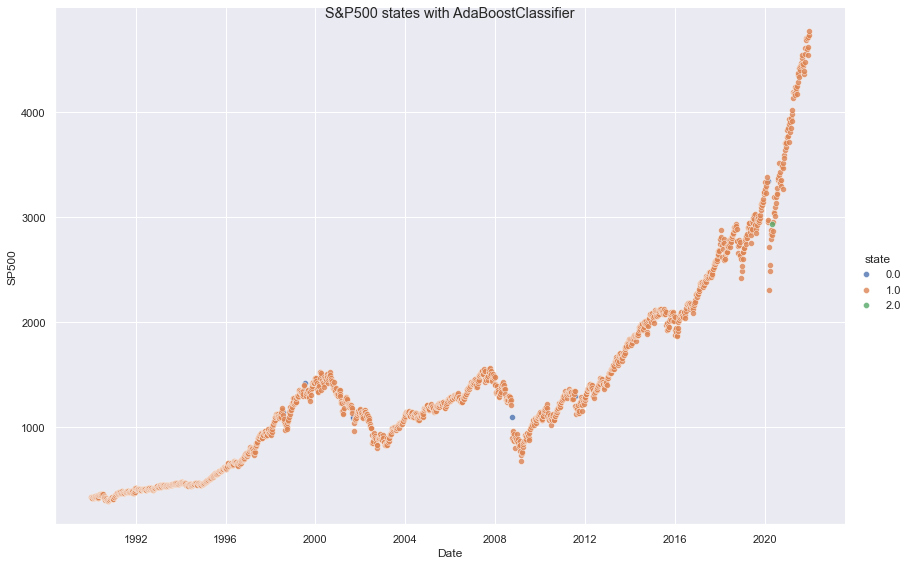

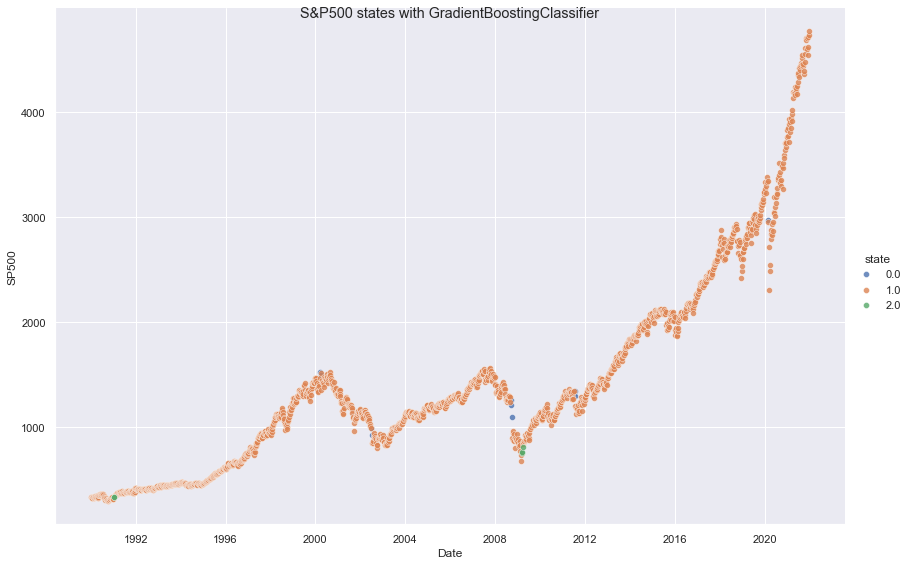

In [32]:
for name, _model in fitted_model.items():
    state = _model.predict(master_monthly2)
    predicted_state = pd.DataFrame(state, columns = ["state"],index = master_monthly2.index)
    graph_state(predicted_state,sp500,name,"state" )

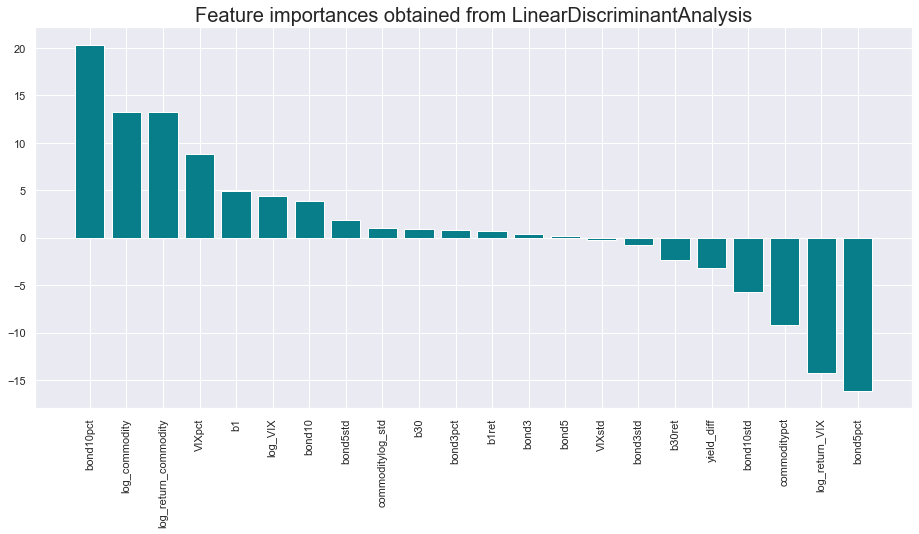

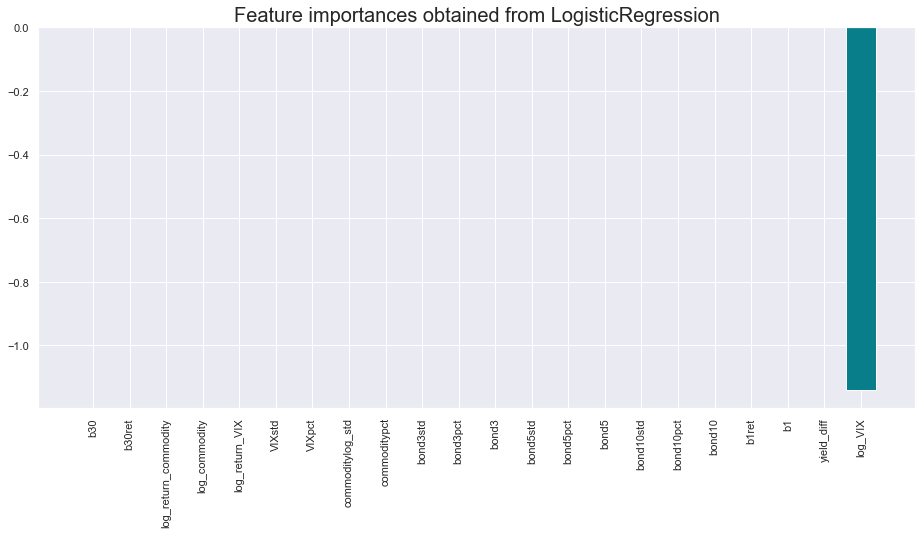

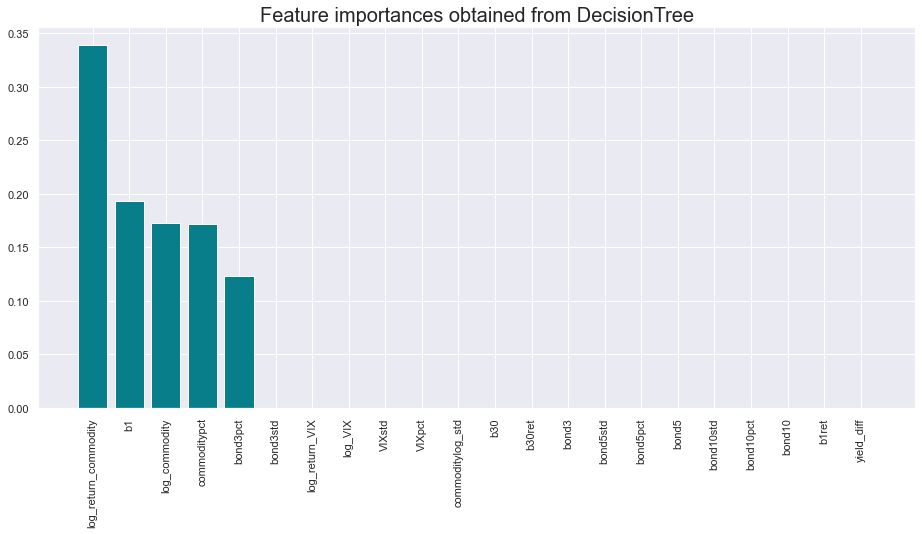

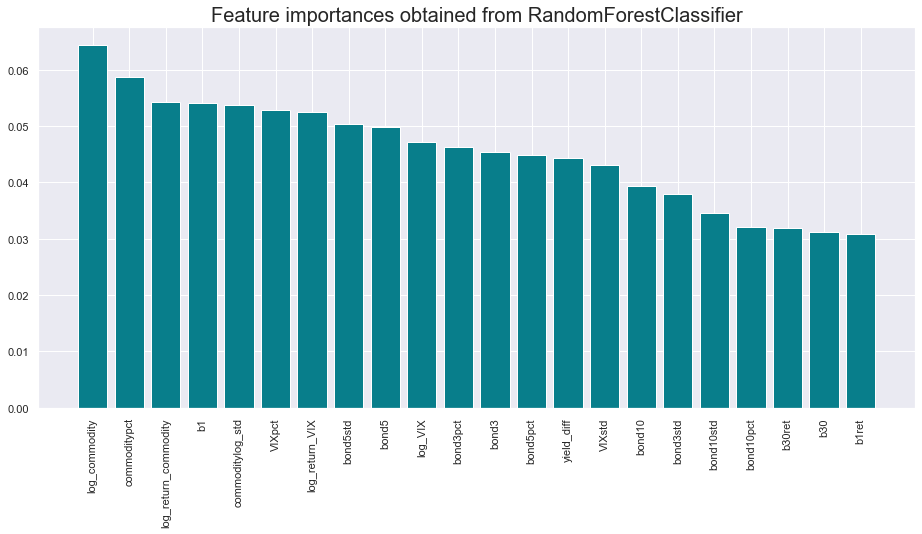

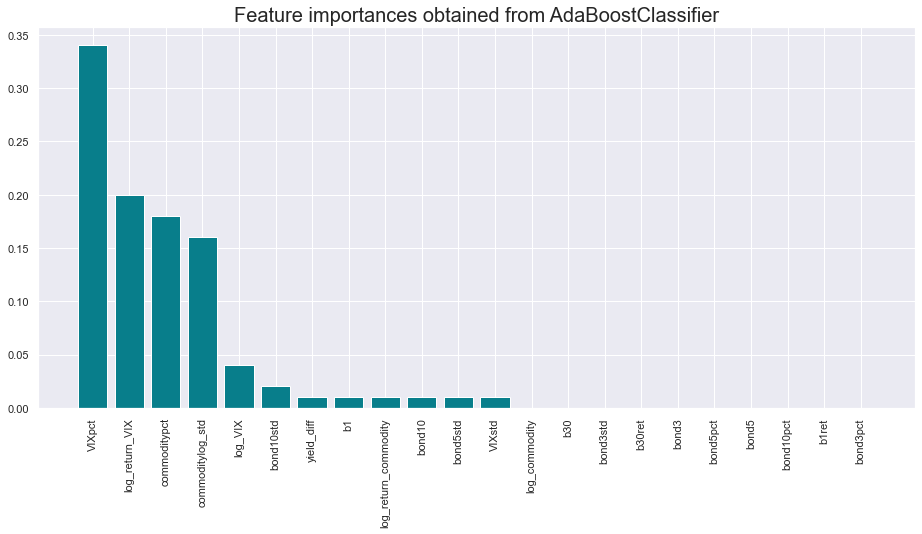

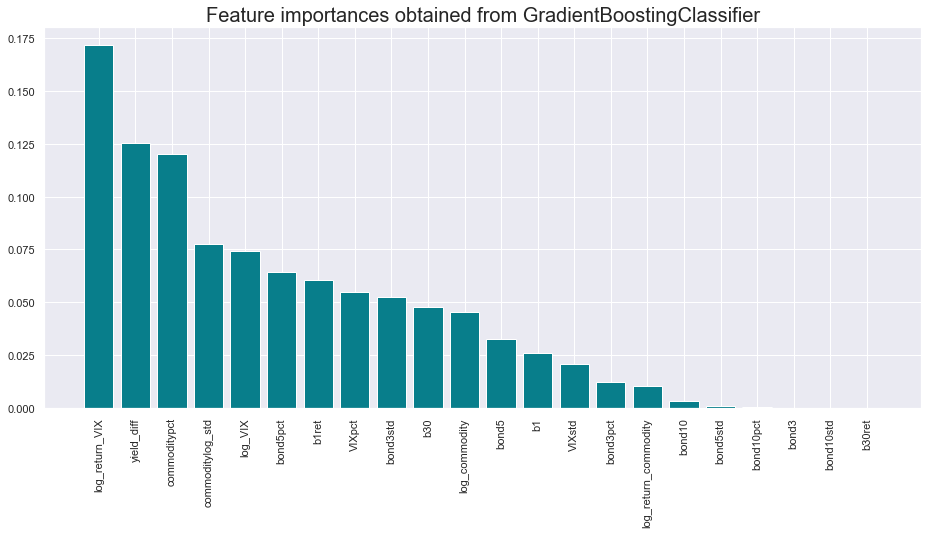

In [33]:
# feature importance
for name, _model in fitted_model.items():
    if(name == 'LinearDiscriminantAnalysis' or name == 'LogisticRegression'):
        importances = pd.DataFrame(data={'Attribute': master_monthly2.columns,'Importance': _model.coef_[0]})
    elif(name == 'Support Vector Machine'):
        continue
    else:
        importances = pd.DataFrame(data={'Attribute': master_monthly2.columns,'Importance': _model.feature_importances_})
    importances = importances.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(14, 7))
    plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
    plt.title('Feature importances obtained from '+name, size=20)
    plt.xticks(rotation='vertical')
    plt.show()

## Back Testing

In [34]:
#convert kmeans and HMM state to the same standard
# bad =0, hold = 1, long = 2
condlistK = [Kmean_state['state'] == 0, Kmean_state['state'] == 1,Kmean_state['state'] == 2]
choicelistK = [1,2,0 ]
condlistH = [HMM_state['state'] == 0, HMM_state['state'] == 1,HMM_state['state'] == 2]
choicelistH = [2,1,0 ]

Kmean_state['Kmean_Predicted'] = np.select(condlistK, choicelistK)
HMM_state['HMM_Predicted'] = np.select(condlistH, choicelistH)

In [35]:
y_monthly2['HMM_Predicted']= HMM_state['HMM_Predicted']
y_monthly2['Kmean_Predicted'] = Kmean_state['Kmean_Predicted']

In [36]:
model_name = {'LinearDiscriminantAnalysis': 'Linear',
        'LogisticRegression': 'Logistic',
        'Support Vector Machine': 'SVM',
        'DecisionTree': 'DT',
        'RandomForestClassifier': 'RF',
        'AdaBoostClassifier': 'Ada',
        'GradientBoostingClassifier':'GBDT',
        'Kmean':'Kmean',
        'HMM':'HMM'}

In [37]:
master_monthly.sort_index(ascending=True,inplace=True)
backtest = pd.DataFrame()
backtest["market"]=master_monthly['SP500pct'].cumsum()

In [38]:
for longname, shortname in model_name.items():
    print('start backtest ' +longname)
    backtest[shortname]=None
    backtest[shortname].iloc[0] = 0
    yname = longname+"_Predicted"
    for i in range(1,y_monthly2.shape[0]):
        if y_monthly2[yname].iloc[i] == 0:
            # short market
            backtest[shortname].iloc[i] = backtest[shortname].iloc[i-1] - master_monthly["SP500pct"].iloc[i]

        elif y_monthly2[yname].iloc[i] == 1:
            # long market
            backtest[shortname].iloc[i] = backtest[shortname].iloc[i-1] + master_monthly["SP500pct"].iloc[i]

        else: # y_monthly2[yname].iloc[i] == 2:
            # super good market
            backtest[shortname].iloc[i] = backtest[shortname].iloc[i-1] + 1.5*master_monthly["SP500pct"].iloc[i]

start backtest LinearDiscriminantAnalysis
start backtest LogisticRegression
start backtest Support Vector Machine
start backtest DecisionTree
start backtest RandomForestClassifier
start backtest AdaBoostClassifier
start backtest GradientBoostingClassifier
start backtest Kmean
start backtest HMM


<AxesSubplot:xlabel='Date'>

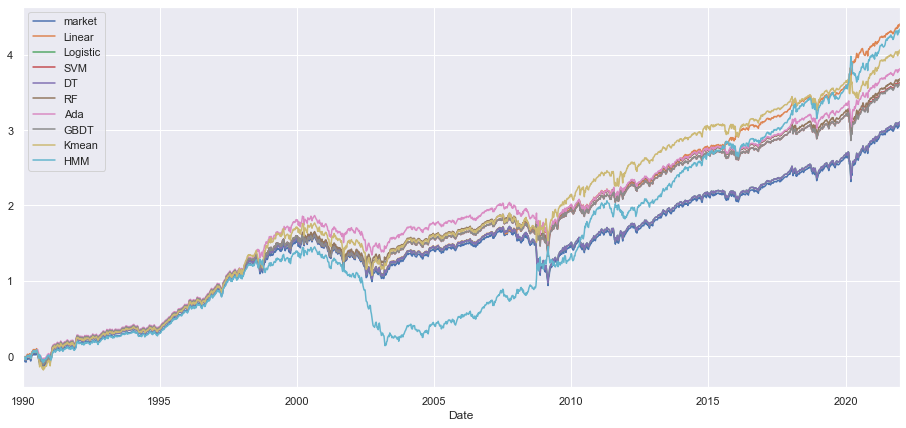

In [39]:
backtest.plot(figsize=(14,7))

In [40]:
#result of sum of backtesting
backtest.loc['2021-12-26']

market       3.076
Linear      4.4085
Logistic     3.111
SVM         3.6325
DT           3.111
RF          3.6825
Ada         3.8165
GBDT        3.6205
Kmean        4.065
HMM         4.3415
Name: 2021-12-26 00:00:00, dtype: object

In [41]:
sharpe_ratio={}

for short in model_name.values():
    ratio = (backtest[short].iloc[-1]-backtest["market"].iloc[-1]) / backtest[short].std()
    sharpe_ratio[short] = [ratio]
    
pd.DataFrame(sharpe_ratio,index=["Sharpe_Ratio"]).T

,Sharpe_Ratio
Linear,1.194662
Logistic,0.045621
SVM,0.583450
DT,0.045621
RF,0.624242
Ada,0.753370
GBDT,0.571599
Kmean,0.892992
HMM,1.070205
